### **Imports**

In [2062]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2063]:
import torch
import torch.nn as nn

In [2064]:
import importlib
import utils, models, training_utils
importlib.reload(utils)
importlib.reload(models)
importlib.reload(training_utils)

<module 'training_utils' from '/Users/pawelgrzeszczyk/Documents/02_studies/master/portfolio-optimization-dl/main/modeling/training_utils.py'>

### **Device**

In [2065]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback to CPU if MPS isn't available

print(f"Using device: {device}")

Using device: mps


### **Reading the dataset**

In [2066]:
# Reading data, renaming columns and reordering
data = pd.read_csv('../data/data_files/w20_stock.csv').filter(regex='^Close_')
data.columns = [x.split('_')[1].split('.')[0] for x in data.columns]
data['Date'] = pd.read_csv('../data/data_files/w20_stock.csv')['Date']
data.insert(0, 'Date', data.pop('Date'))

# Date as index
data = data.set_index('Date')

# Getting the first row with no NaN values
first_full_row = data.dropna().first_valid_index()
print(f'First row with no NaN values is from: ({first_full_row})')

# Removing rows with NaN values
data = data.loc[first_full_row:]
print(f'Number of rows with NaN values removed: {first_full_row}')
print(f'Number of rows with no NaN values: {data.shape[0]}')

# Take only sample of assets
data = data[data.columns[:4]]

data.head()

First row with no NaN values is from: (2021-05-27)
Number of rows with NaN values removed: 2021-05-27
Number of rows with no NaN values: 792


,ALE,ALR,BDX,CDR
Date,,,,
2021-05-27,58.279999,32.900002,313.5,175.500000
2021-05-28,58.500000,33.990002,306.0,178.580002
2021-05-31,57.660000,33.740002,298.5,168.740005
2021-06-01,59.209999,34.480000,299.0,153.380005
2021-06-02,59.180000,34.410000,295.0,161.580002


In [2067]:
# data, X_SEQ_LEN = utils.generate_data(end_date=datetime(2023, 1, 30),
#                                    days=100,
#                                    num_ascending_start=2,
#                                    num_descending_start=2,
#                                    swap_count=10)
# # How many "next" days should be used to set the true label
# Y_SEQ_LEN = 1

# data

### **Prepare data for the model**

**Calculating percentage changes**

In [2068]:
# Calculate daily returns
data_returns = data.pct_change().dropna()
data_returns['SAVE'] = 0

ASSET_COUNT = data_returns.shape[1]

data_returns

,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-05-28,0.003775,0.033131,-0.023923,0.017550,0
2021-05-31,-0.014359,-0.007355,-0.024510,-0.055101,0
2021-06-01,0.026882,0.021932,0.001675,-0.091028,0
2021-06-02,-0.000507,-0.002030,-0.013378,0.053462,0
2021-06-04,-0.006928,0.009881,0.011864,0.059537,0
...,...,...,...,...,...
2024-07-15,-0.003397,0.000000,0.000000,0.033113,0
2024-07-16,-0.021677,-0.046960,-0.017531,-0.020147,0
2024-07-17,-0.030658,-0.023859,-0.022305,-0.004361,0


In [2069]:
data_model = data_returns.copy()

def calculate_rsi(data, window=15):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for stock in data_model.columns:
    data_model[f'{stock}_MA_15'] = data_model[stock].rolling(window=15).mean()  # 15-day moving average
    data_model[f'{stock}_STD_15'] = data_model[stock].rolling(window=15).std()  # 15-day moving std dev
    data_model[f'{stock}_CUM_RET'] = (1 + data_model[stock]).cumprod() - 1     # Cumulative returns
    data_model[f'{stock}_RSI'] = calculate_rsi(data_model[stock])              # RSI

data_model = data_model.drop(columns='SAVE_RSI')
data_model = data_model.dropna()

print(f'Data shape: {data_model.shape}')
data_model.head()

Data shape: (777, 24)


,ALE,ALR,BDX,CDR,SAVE,ALE_MA_15,ALE_STD_15,ALE_CUM_RET,ALE_RSI,ALR_MA_15,...,BDX_STD_15,BDX_CUM_RET,BDX_RSI,CDR_MA_15,CDR_STD_15,CDR_CUM_RET,CDR_RSI,SAVE_MA_15,SAVE_STD_15,SAVE_CUM_RET
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-18,0.016246,-0.022571,-0.012259,0.015801,0,0.002069,0.012468,0.030371,52.688215,0.002832,...,0.014646,-0.100478,52.352969,0.004225,0.048693,0.047635,49.894492,0.0,0.0,0
2021-06-21,-0.010824,-0.009062,0.000000,-0.002611,0,0.001096,0.012888,0.019218,47.182025,0.000019,...,0.013950,-0.100478,54.598512,0.002881,0.048577,0.044900,48.810093,0.0,0.0,0
2021-06-22,-0.019360,0.020944,0.010638,-0.030538,0,0.000762,0.013372,-0.000515,48.997486,0.001906,...,0.013443,-0.090909,56.504728,0.004519,0.046867,0.012991,51.530591,0.0,0.0,0
2021-06-23,0.034335,0.043051,-0.007018,0.001237,0,0.001259,0.014502,0.033802,51.422919,0.003314,...,0.013414,-0.097289,48.338856,0.010670,0.038789,0.014245,55.779054,0.0,0.0,0
2021-06-24,0.038008,0.016898,0.021201,0.011461,0,0.003827,0.017306,0.073095,58.085320,0.004576,...,0.014534,-0.078150,56.291488,0.007870,0.036952,0.025869,46.837275,0.0,0.0,0


**Convert to target shape**

In [2070]:
X_SEQ_LEN = 5
Y_SEQ_LEN = 5

In [2071]:
import numpy as np
import torch

X_train, X_test, Y_train, Y_test = utils.create_sequences(data_returns = data_model, 
                                                          X_seq_len = X_SEQ_LEN, 
                                                          Y_seq_len = Y_SEQ_LEN, 
                                                          test_size=0.3,
                                                          device=device)

In [2076]:
print(f'X shape: \n\t{X_train.shape}')
print(f'X sample: \n\t{X_train[0]}')

X shape: 
	torch.Size([537, 5, 24])
X sample: 
	tensor([[ 1.6246e-02, -2.2571e-02, -1.2259e-02,  1.5801e-02,  0.0000e+00,
          2.0689e-03,  1.2468e-02,  3.0371e-02,  5.2688e+01,  2.8322e-03,
          2.2071e-02,  3.9818e-02,  4.3070e+01, -6.9334e-03,  1.4646e-02,
         -1.0048e-01,  5.2353e+01,  4.2253e-03,  4.8693e-02,  4.7635e-02,
          4.9894e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0824e-02, -9.0616e-03,  0.0000e+00, -2.6107e-03,  0.0000e+00,
          1.0956e-03,  1.2888e-02,  1.9218e-02,  4.7182e+01,  1.9407e-05,
          2.0571e-02,  3.0395e-02,  4.4922e+01, -5.3385e-03,  1.3950e-02,
         -1.0048e-01,  5.4599e+01,  2.8812e-03,  4.8577e-02,  4.4900e-02,
          4.8810e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9360e-02,  2.0944e-02,  1.0638e-02, -3.0538e-02,  0.0000e+00,
          7.6222e-04,  1.3372e-02, -5.1474e-04,  4.8997e+01,  1.9060e-03,
          2.1137e-02,  5.1976e-02,  5.3494e+01, -2.9953e-03,  1.3443e-02,
         -9.09

In [2077]:
print(f'Y shape: \n\t{Y_train.shape}')
print(f'Y sample: \n\t{Y_train[0]}')

Y shape: 
	torch.Size([537, 5, 24])
Y sample: 
	tensor([[ 2.6543e-02,  4.6309e-03, -1.9031e-02, -1.7773e-03,  0.0000e+00,
          6.0582e-03,  1.7965e-02,  1.0158e-01,  5.6881e+01,  4.2258e-03,
          2.3328e-02,  1.2097e-01,  4.9344e+01, -3.3292e-03,  1.4727e-02,
         -9.5694e-02,  4.4670e+01,  3.7821e-03,  3.4111e-02,  2.4046e-02,
          4.5432e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0498e-03, -1.2744e-02,  5.2910e-03,  3.2161e-02,  0.0000e+00,
          5.4705e-03,  1.8154e-02,  9.7117e-02,  4.8319e+01,  3.1268e-03,
          2.3737e-02,  1.0669e-01,  4.7997e+01, -5.1976e-04,  1.1553e-02,
         -9.0909e-02,  5.7939e+01,  6.4869e-03,  3.4679e-02,  5.6980e-02,
          5.3184e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.4398e-02, -3.1310e-02, -1.4035e-02,  1.5418e-02,  0.0000e+00,
          6.8713e-03,  1.8781e-02,  1.2388e-01,  5.3633e+01,  2.5303e-03,
          2.4523e-02,  7.2036e-02,  4.8893e+01, -2.2670e-03,  1.1478e-02,
         -1.03

**True labels**

| Function                  | Arguments      | Description                                                                  |
|---------------------------|----------------|------------------------------------------------------------------------------|
| `get_Y_max_one`            | `Y`            | Pick one asset with the highest returns                                       |
| `get_Y_max_light`          | `Y`            | Distribute weights among assets with positive returns depending on the returns value |
| `get_Y_sharpe_one`         | `X, Y`         | Pick one asset with the highest Sharpe ratio                                  |
| `get_Y_sharpe_light`       | `X, Y`         | Distribute weights among assets with positive returns depending on the Sharpe ratio value |

In [2078]:
# Y_train_true_labels = utils.get_Y_sharpe_light(X_train, Y_train).to(device)
# Y_test_true_labels = utils.get_Y_sharpe_light(X_test, Y_test).to(device)
Y_train_true_labels = utils.get_Y_max_light(Y_train[:, :, :ASSET_COUNT]).to(device)
Y_test_true_labels = utils.get_Y_max_light(Y_test[:, :, :ASSET_COUNT]).to(device)

print(f'Y_true_labels shape: \n\t{Y_true_labels.shape}')
print(f'Y_true_labels sample: \n\t{Y_true_labels[0]}')

Y_true_labels shape: 
	torch.Size([72, 5])
Y_true_labels sample: 
	tensor([0.8247, 0.1753, 0.0000, 0.0000, 0.0000])


### **Model**

In [2079]:
input_size = X_train.shape[2]
hidden_size = 128
output_size = Y_true_labels.shape[1]

# Create the model
model = models.LSTMModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  num_layers=1,
                  dropout_rate=0.5,
                  device=device,
                  max_norm_value=0.0).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/Users/pawelgrzeszczyk/Documents/02_studies/master/portfolio-optimization-dl/main/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### **Training**

In [2080]:
model_results = training_utils.train(
                    model=model,
                    X_train=X_train,
                    Y_train=Y_train,
                    Y_train_true_labels=Y_train_true_labels,
                    X_test=X_test,
                    Y_test=Y_test,
                    Y_test_true_labels=Y_test_true_labels,
                    optimizer=optimizer,
                    criterion=criterion,
                    profit_calc_fn=utils.calculate_portfolio_return,
                    asset_count=ASSET_COUNT,
                    epochs=1000,
                    print_every=100)

Epoch: 100 | train_loss: 0.0962 | train_profit: 0.24% | test_loss: 0.0866 | test_profit: 0.29%
Epoch: 200 | train_loss: 0.0940 | train_profit: 0.41% | test_loss: 0.0875 | test_profit: 0.30%
Epoch: 300 | train_loss: 0.0883 | train_profit: 0.77% | test_loss: 0.0908 | test_profit: 0.31%
Epoch: 400 | train_loss: 0.0805 | train_profit: 1.51% | test_loss: 0.0951 | test_profit: 0.32%
Epoch: 500 | train_loss: 0.0717 | train_profit: 2.58% | test_loss: 0.0968 | test_profit: 0.35%
Epoch: 600 | train_loss: 0.0624 | train_profit: 4.39% | test_loss: 0.1021 | test_profit: 0.39%
Epoch: 700 | train_loss: 0.0542 | train_profit: 6.81% | test_loss: 0.1094 | test_profit: 0.44%
Epoch: 800 | train_loss: 0.0475 | train_profit: 9.99% | test_loss: 0.1172 | test_profit: 0.46%
Epoch: 900 | train_loss: 0.0418 | train_profit: 13.30% | test_loss: 0.1230 | test_profit: 0.49%
Epoch: 1000 | train_loss: 0.0365 | train_profit: 18.37% | test_loss: 0.1286 | test_profit: 0.49%


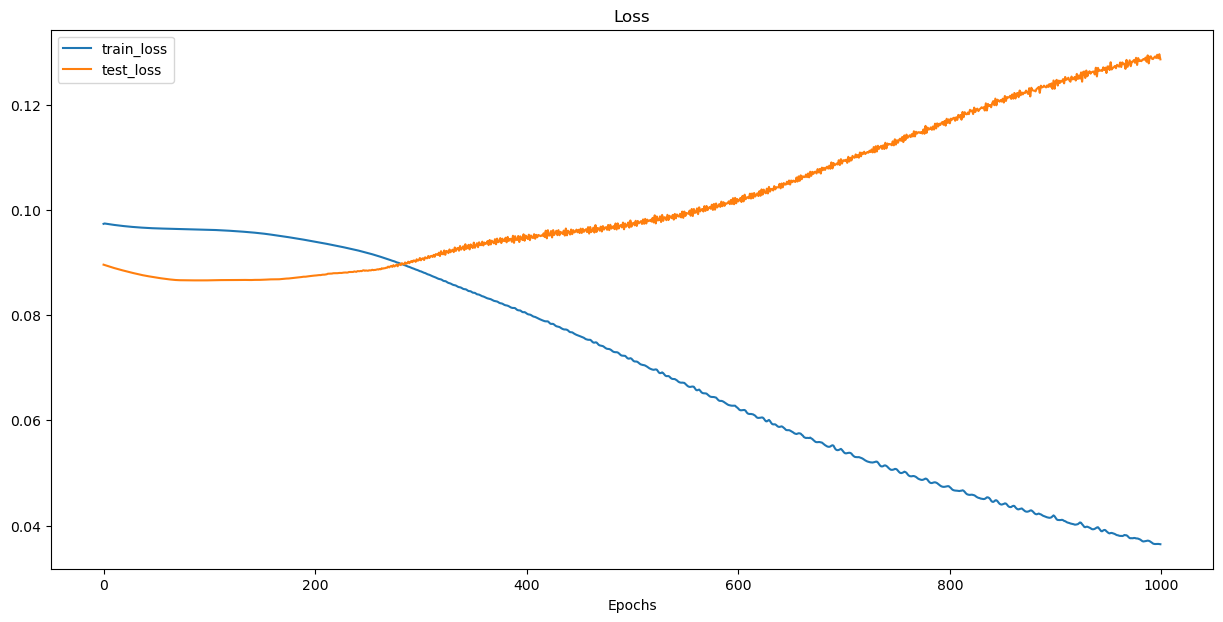

In [2081]:
utils.plot_loss_curves(model_results)

## **Evaluation**

In [2082]:
with torch.no_grad():
    training_output_weights = model(X_train)

with torch.no_grad():
    testing_output_weights = model(X_test)

In [2083]:
all_output_weights = torch.cat((training_output_weights, testing_output_weights))
all_output_weights.shape

torch.Size([768, 5])

In [2084]:
all_output_weights_df = pd.DataFrame(all_output_weights.cpu().numpy(), columns=data_model.columns[:ASSET_COUNT])
all_output_weights_df['Date'] = data_model.index[X_SEQ_LEN: None if Y_SEQ_LEN == 1 else -(Y_SEQ_LEN - 1)]
all_output_weights_df['Date'] = pd.to_datetime(all_output_weights_df['Date'])
all_output_weights_df = all_output_weights_df.set_index('Date')
all_output_weights_df

,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-06-25,0.657605,0.049218,0.013789,0.279100,0.000288
2021-06-28,0.512657,0.083560,0.008312,0.395421,0.000050
2021-06-29,0.579953,0.290723,0.013233,0.116007,0.000084
2021-06-30,0.796946,0.065849,0.007836,0.128773,0.000595
2021-07-01,0.638307,0.099608,0.010790,0.251084,0.000211
...,...,...,...,...,...
2024-07-09,0.039141,0.056845,0.487169,0.409084,0.007761
2024-07-10,0.053518,0.026245,0.593424,0.255595,0.071218
2024-07-11,0.030879,0.111664,0.252032,0.603953,0.001472


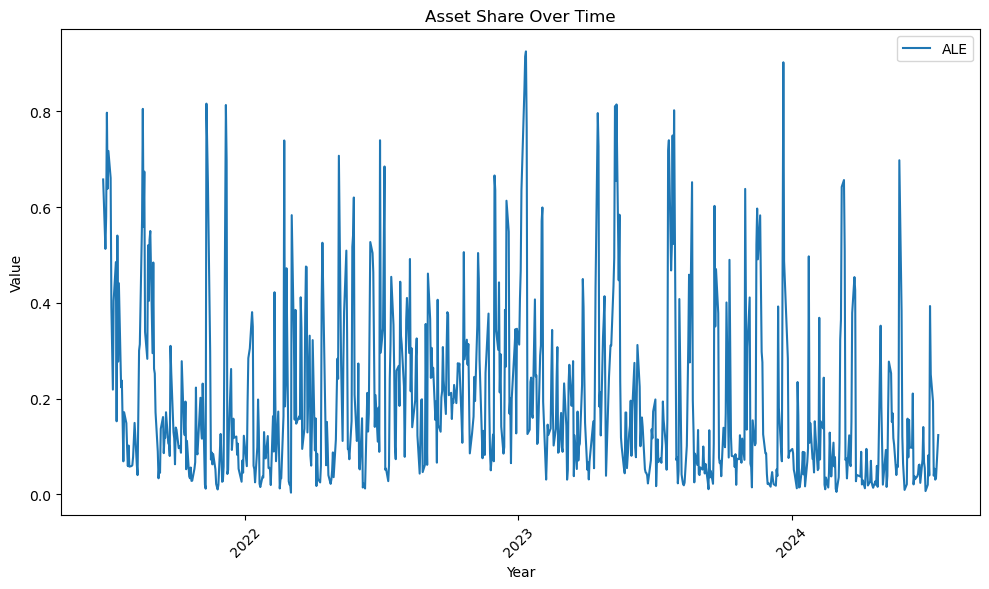

In [2085]:
utils.plot_asset_share(all_output_weights_df[['ALE']])
# utils.plot_asset_share(all_output_weights_df)

### **Profit calculation**

In [2086]:
max_daily_returns, max_total_returns = utils.calculate_max_return(Y_test[:, :, :ASSET_COUNT])

print(f'Total max returns: {max_total_returns}')
# print(f'Daily max returns: {max_daily_returns}')

Total max returns: 123.92472839355469


In [2087]:
portfolio_daily_returns, portfolio_total_returns = utils.calculate_portfolio_return(testing_output_weights, 
                                                                                    Y_test[:, :, :ASSET_COUNT])

print(f'Total portfolio returns: {portfolio_total_returns}')
# print(f'Daily portfolio returns: {portfolio_daily_returns}')

Total portfolio returns: 0.4874560832977295


In [2088]:
print(f'Earned profit vs max profit: {portfolio_total_returns:.2f}% vs {max_total_returns:.2f}%')

Earned profit vs max profit: 0.49% vs 123.92%
